In [1]:
# load dataset cross validation

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import re
import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split
from augmentations import avg_aug

%load_ext autoreload
%autoreload 2

In [3]:
def _parse_function_with_DA(impath, label):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, shape)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    return image, label

def _parse_function_without_DA(impath, label):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, shape)
    image = image / 255.
    return image, label

# return tf.data
def load_dataset(
    db_dict=None, db_key='flickr', multiclass=False, 
    data_augmentation=False, shape=(224, 224), color='rgb', 
    load_csv=False, class_weights=False, batch_size=16
):
    
    db_dir = db_dict.get(db_key)
    _classes = ('attack', 'bonafide') if not multiclass else ('bonafide', 'print', 'screen')
    imlist = [*list_images(db_dir)]
    bf_list, att_list = [], []
    
    
    if multiclass:
        # generate multiclass_y vector
        X, y = [], []
        regex_str = "|".join(_classes)
        
        for imdir in imlist:
            regex_res = re.search(regex_str, imdir)
            regex_class = regex_res.group()
            _id_class = _classes.index(regex_class)
            X.append(imdir)
            y.append(_id_class)
        
        X = np.array(X)
        y = tf.keras.utils.to_categorical(y)

    else:
        for imdir in imlist:
            if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
                bf_list.append(imdir)
            else: # identify attack class
                att_list.append(imdir)
                
        bf_y = np.ones(len(bf_list))
        att_y = np.zeros(len(att_list)) # use labelencoder here
        # split|load data into train|test|val
        X = np.concatenate([att_list, bf_list])
        y = np.concatenate([att_y, bf_y])
        y = tf.keras.utils.to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
    
    # train dataset
    train_dataset = tf.cast(X_train, dtype=tf.string)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, tf.cast(y_train, tf.float32)))
    train_dataset = train_dataset.shuffle(batch_size**2)
    train_dataset = train_dataset.map(_parse_function_with_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.batch(batch_size)
    
    # val dataset
    val_dataset = tf.cast(X_val, dtype=tf.string)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset, tf.cast(y_val, tf.float32)))
    val_dataset = val_dataset.shuffle(batch_size**2)
    val_dataset = val_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.cache()
    val_dataset = val_dataset.batch(1)
    
    # test dataset
    test_dataset = tf.cast(X_test, dtype=tf.string)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, tf.cast(y_test, tf.float32)))
    test_dataset = test_dataset.shuffle(batch_size**2)
    test_dataset = test_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.cache()
    test_dataset = test_dataset.batch(1)
    
    return train_dataset, val_dataset, test_dataset

In [10]:
multiclass = False
batch_size = 16
shape = (224, 224)

_classes = ('attack', 'bonafide') if not multiclass else ('bonafide', 'printed', 'screen')
_bf_index = _classes.index('bonafide')

In [11]:
datasets = {
    'flickr': '../data/02_intermediate/flickr',
    'splunk': '../data/02_intermediate/splunk'
}

In [12]:
train_ds, val_ds, test_ds = load_dataset(db_dict=datasets, db_key='flickr', batch_size=1, multiclass=multiclass)

In [13]:
len(train_ds), len(test_ds), len(val_ds)

(8385, 2795, 2795)

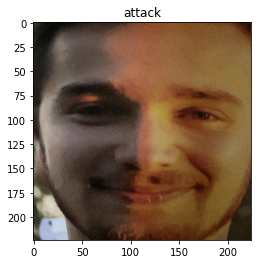

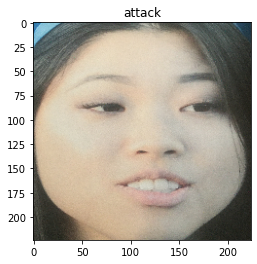

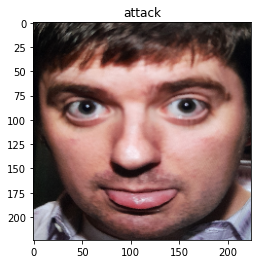

2022-12-09 23:46:05.040818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
for bs in test_ds.take(3):
    im, lb = bs
    plt.title(_classes[np.argmax(lb[0])])
    # plt.title(_classes[int(lb[0])])
    plt.imshow(im[0])
    plt.show()

In [9]:
# separar identidades en base de datos flickr. Tienen un id asociado "F000xx"
# puta la wea splunk tambien